In [9]:
pip install torch scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 79.2 MB/s  0:00:00 83.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

✅ Successfully loaded data!
   Rows (Envs): 40960
   Columns:     4849
✅ Fixed 'gt_fric_force' column types.

--- Target Property Distributions ---


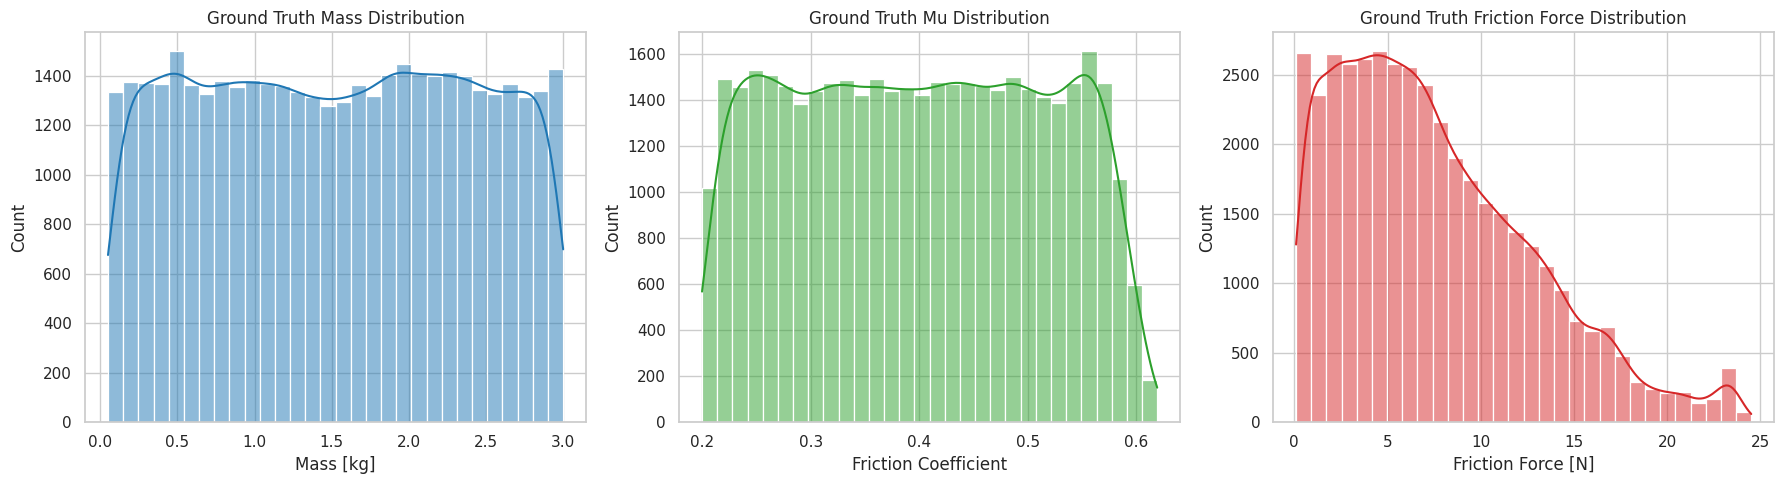


ANALYZING SAMPLE #26008
GT Mass: 2.552 kg
GT Mu:   0.233
GT Fric Force (Target): 6.317 N
Time Window: 63 -> 83


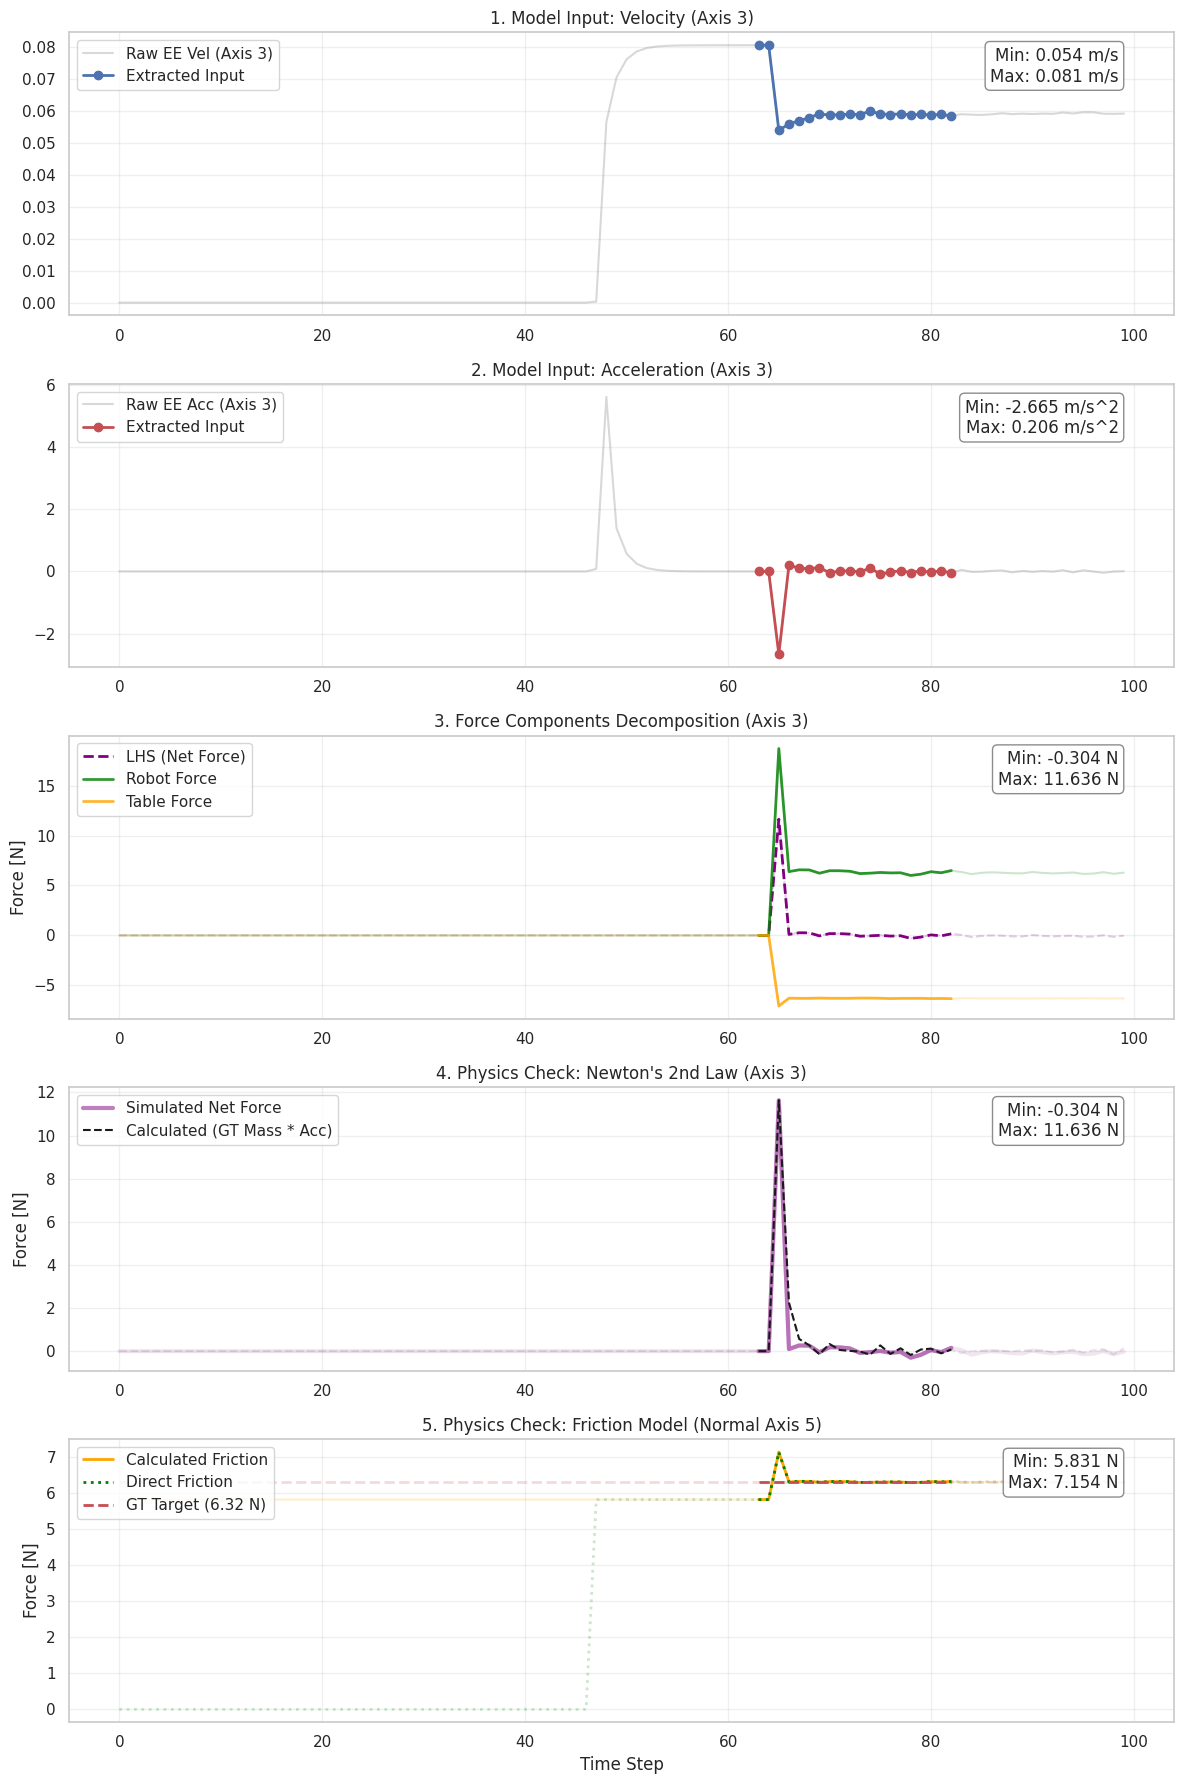

In [11]:

# ==========================================
# 1. CONFIGURATION
# ==========================================
CSV_PATH = "/home/psxkf4/IsaacLab/source/collected_data/offline_data_8192.csv" 

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ==========================================
# 2. LOAD DATA
# ==========================================
if not os.path.exists(CSV_PATH):
    print(f"❌ Error: File not found at {CSV_PATH}")
    print("Please check the path and try again.")
else:
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Successfully loaded data!")
    print(f"   Rows (Envs): {df.shape[0]}")
    print(f"   Columns:     {df.shape[1]}")
    
    # Optional: Display the dataframe
    # display(df)

# --- FIX DATA TYPES ---
# The 'gt_fric_force' column might be saved as strings (e.g., "[4.23]"). 
def clean_force_col(x):
    if isinstance(x, str):
        return float(x.strip('[]'))
    return x

if 'gt_fric_force' in df.columns:
    df['gt_fric_force'] = df['gt_fric_force'].apply(clean_force_col)
    print("✅ Fixed 'gt_fric_force' column types.")

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def get_sequence_data(row, prefix, seq_len=100, num_axes=6):
    """Reconstructs (100, 6) array from flattened columns like 'prefix_t0_ax0'"""
    data = np.zeros((seq_len, num_axes))
    for t in range(seq_len):
        for ax in range(num_axes):
            col = f"{prefix}_t{t}_ax{ax}"
            if col in row:
                data[t, ax] = row[col]
    return data

def get_flat_window(row, prefix, window_size=10):
    """Reconstructs 1D array from columns like 'prefix_0', 'prefix_1'"""
    data = np.zeros(window_size)
    for i in range(window_size):
        col = f"{prefix}_{i}"
        if col in row:
            data[i] = row[col]
    return data

# ==========================================
# 4. DISTRIBUTION PLOTS (Targets)
# ==========================================
if 'df' in locals():
    print("\n--- Target Property Distributions ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Mass
    sns.histplot(df['gt_mass'], kde=True, ax=axes[0], color='tab:blue', bins=30)
    axes[0].set_title('Ground Truth Mass Distribution')
    axes[0].set_xlabel('Mass [kg]')
    
    # Friction Coeff
    sns.histplot(df['gt_mu'], kde=True, ax=axes[1], color='tab:green', bins=30)
    axes[1].set_title('Ground Truth Mu Distribution')
    axes[1].set_xlabel('Friction Coefficient')
    
    # Friction Force
    sns.histplot(df['gt_fric_force'], kde=True, ax=axes[2], color='tab:red', bins=30)
    axes[2].set_title('Ground Truth Friction Force Distribution')
    axes[2].set_xlabel('Friction Force [N]')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. INTEGRATED SAMPLE ANALYSIS (UPDATED WITH HIGHLIGHTS + MIN/MAX)
# ==========================================
if 'df' in locals():
    # --- CONFIGURATION ---
    AXIS_MOTION = 3   
    AXIS_VERTICAL = 5 
    G = 9.81

    # 1. Pick a single random sample for ALL plots
    sample_idx = np.random.randint(0, len(df))
    row = df.iloc[sample_idx]
    
    print(f"\n=======================================================")
    print(f"ANALYZING SAMPLE #{sample_idx}")
    print(f"=======================================================")
    print(f"GT Mass: {row['gt_mass']:.3f} kg")
    print(f"GT Mu:   {row['gt_mu']:.3f}")
    
    gt_fric_force_val = row['gt_fric_force']
    if isinstance(gt_fric_force_val, str):
        gt_fric_force_val = float(gt_fric_force_val.strip('[]'))
    print(f"GT Fric Force (Target): {gt_fric_force_val:.3f} N")
    print(f"Time Window: {int(row['start_t'])} -> {int(row['end_t'])}")

    # --- HELPER TO ADD MIN/MAX TEXT ---
    def add_min_max_text(ax, data, unit=""):
        dmin, dmax = np.min(data), np.max(data)
        stats_text = f"Min: {dmin:.3f} {unit}\nMax: {dmax:.3f} {unit}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                horizontalalignment='right', verticalalignment='top', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

    # --- 2. EXTRACT DATA ---
    raw_acc = get_sequence_data(row, "raw_ee_acc")
    raw_vel = get_sequence_data(row, "raw_ee_vel")
    
    input_cols = [c for c in df.columns if "input_acc_" in c]
    win_len = len(input_cols)
    input_acc = get_flat_window(row, "input_acc", win_len)
    input_vel = get_flat_window(row, "input_vel", win_len)
    
    lhs_wrench = get_sequence_data(row, "pinn_LHS_wrench")      
    rhs_acc = get_sequence_data(row, "pinn_RHS_acc")            
    robot_wrench = get_sequence_data(row, "pinn_robot_wrench")  
    table_wrench = get_sequence_data(row, "pinn_table_wrench")  
    
    start_t = int(row['start_t'])
    time_steps = np.arange(start_t, start_t + win_len)

    # --- 3. CALCULATIONS ---
    # Newton Check
    net_force_sim = lhs_wrench[:, AXIS_MOTION]
    acc_sim = rhs_acc[:, AXIS_MOTION]
    net_force_calc = row['gt_mass'] * acc_sim

    # Friction Check
    robot_force_vertical = robot_wrench[:, AXIS_VERTICAL]
    normal_force_calc = (row['gt_mass'] * G) - robot_force_vertical
    fric_force_calc_profile = row['gt_mu'] * normal_force_calc
    
    normal_force_direct = table_wrench[:, AXIS_VERTICAL]
    fric_force_direct_profile = row['gt_mu'] * normal_force_direct
    
    fric_force_gt_line = np.full_like(fric_force_calc_profile, gt_fric_force_val)

    # --- 4. PLOTTING ---
    fig, axes = plt.subplots(5, 1, figsize=(12, 18))
    
    # Plot 1: Velocity Input
    axes[0].plot(raw_vel[:, AXIS_MOTION], label=f'Raw EE Vel (Axis {AXIS_MOTION})', color='gray', alpha=0.3)
    axes[0].plot(time_steps, input_vel, 'b-o', linewidth=2, label='Extracted Input')
    
    axes[0].set_title(f"1. Model Input: Velocity (Axis {AXIS_MOTION})")
    add_min_max_text(axes[0], input_vel, "m/s") # Add stats
    axes[0].legend(loc='upper left')

    # Plot 2: Acceleration Input
    axes[1].plot(raw_acc[:, AXIS_MOTION], label=f'Raw EE Acc (Axis {AXIS_MOTION})', color='gray', alpha=0.3)
    axes[1].plot(time_steps, input_acc, 'r-o', linewidth=2, label='Extracted Input')
    
    axes[1].set_title(f"2. Model Input: Acceleration (Axis {AXIS_MOTION})")
    add_min_max_text(axes[1], input_acc, "m/s^2") # Add stats
    axes[1].legend(loc='upper left')

    # Plot 3: Component Breakdown
    lhs_val = lhs_wrench[:, AXIS_MOTION]
    robot_val = robot_wrench[:, AXIS_MOTION]
    table_val = table_wrench[:, AXIS_MOTION]
    
    # Background
    axes[2].plot(lhs_val, color='purple', linestyle='--', alpha=0.2)
    axes[2].plot(robot_val, color='green', alpha=0.2)
    axes[2].plot(table_val, color='orange', alpha=0.2)
    
    # Foreground
    net_win = lhs_val[time_steps]
    axes[2].plot(time_steps, net_win, label='LHS (Net Force)', color='purple', linestyle='--', linewidth=2)
    axes[2].plot(time_steps, robot_val[time_steps], label='Robot Force', color='green', alpha=0.8, linewidth=2)
    axes[2].plot(time_steps, table_val[time_steps], label='Table Force', color='orange', alpha=0.8, linewidth=2)
    
    axes[2].set_title(f"3. Force Components Decomposition (Axis {AXIS_MOTION})")
    axes[2].set_ylabel("Force [N]")
    add_min_max_text(axes[2], net_win, "N") # Add stats for Net Force
    axes[2].legend(loc='upper left')

    # Plot 4: Newton's Law Check
    # Background
    axes[3].plot(net_force_sim, color='purple', linewidth=3, alpha=0.1)
    axes[3].plot(net_force_calc, 'k--', linewidth=1.5, alpha=0.1)
    
    # Foreground
    sim_win = net_force_sim[time_steps]
    axes[3].plot(time_steps, sim_win, label='Simulated Net Force', color='purple', linewidth=3, alpha=0.5)
    axes[3].plot(time_steps, net_force_calc[time_steps], 'k--', label='Calculated (GT Mass * Acc)', linewidth=1.5)
    
    axes[3].set_title(f"4. Physics Check: Newton's 2nd Law (Axis {AXIS_MOTION})")
    axes[3].set_ylabel("Force [N]")
    add_min_max_text(axes[3], sim_win, "N") # Add stats for Sim Force
    axes[3].legend(loc='upper left')

    # Plot 5: Friction Model Check
    # Background
    axes[4].plot(fric_force_calc_profile, color='orange', alpha=0.2)
    axes[4].plot(fric_force_direct_profile, color='green', linestyle=':', linewidth=2, alpha=0.2)
    axes[4].plot(fric_force_gt_line, 'r--', linewidth=2, alpha=0.2)

    # Foreground
    calc_win = fric_force_calc_profile[time_steps]
    axes[4].plot(time_steps, calc_win, label='Calculated Friction', color='orange', linewidth=2)
    axes[4].plot(time_steps, fric_force_direct_profile[time_steps], label='Direct Friction', color='green', linestyle=':', linewidth=2)
    axes[4].plot(time_steps, fric_force_gt_line[time_steps], 'r--', label=f'GT Target ({gt_fric_force_val:.2f} N)', linewidth=2)
    
    axes[4].set_title(f"5. Physics Check: Friction Model (Normal Axis {AXIS_VERTICAL})")
    axes[4].set_ylabel("Force [N]")
    axes[4].set_xlabel("Time Step")
    add_min_max_text(axes[4], calc_win, "N") # Add stats for Calculated Friction
    axes[4].legend(loc='upper left')

    for ax in axes:
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [23]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# ==========================================
# 1. DATA PREPARATION & SHAPE CHECKS
# ==========================================
if 'df' in locals():
    print("--- Preparing Data & Checking Shapes ---")
    
    # 1. Identify Input Columns
    acc_cols = [c for c in df.columns if "input_acc_" in c]
    vel_cols = [c for c in df.columns if "input_vel_" in c]
    
    # Sort them numerically (input_acc_0, input_acc_1...)
    acc_cols.sort(key=lambda x: int(x.split('_')[-1]))
    vel_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    print(f"Found {len(acc_cols)} Acceleration columns.")
    print(f"Found {len(vel_cols)} Velocity columns.")

    # 2. Extract Flattened Data
    X_acc_flat = df[acc_cols].values.astype(np.float32)
    X_vel_flat = df[vel_cols].values.astype(np.float32)
    
    # --- FIX: Set Axes to 1 (Translational X only) ---
    num_axes = 1  
    
    # Calculate Sequence Length
    if len(acc_cols) % num_axes != 0:
        print("⚠️ WARNING: Total columns not divisible by axis count!")
        
    seq_len = len(acc_cols) // num_axes
    print(f"Detected Sequence Length: {seq_len} (Total Features: {len(acc_cols)})")
    
    # Reshape to [Batch, Seq_Len, 1]
    X_acc = X_acc_flat.reshape(-1, seq_len, num_axes)
    X_vel = X_vel_flat.reshape(-1, seq_len, num_axes)
    
    print(f"Reshaped Acc Tensor: {X_acc.shape} (Batch, Time, Axes)")
    print(f"Reshaped Vel Tensor: {X_vel.shape} (Batch, Time, Axes)")
    
    # 3. Extract Targets [Mass, Mu]
    y = df[['gt_mass', 'gt_mu']].values.astype(np.float32)
    print(f"Targets Shape: {y.shape}")
    
    # 4. Convert to PyTorch Tensors
    X_acc_tensor = torch.tensor(X_acc)
    X_vel_tensor = torch.tensor(X_vel)
    y_tensor = torch.tensor(y)
    
    # 5. Train/Val Split
    indices = np.arange(len(df))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    train_dataset = TensorDataset(X_acc_tensor[train_idx], X_vel_tensor[train_idx], y_tensor[train_idx])
    val_dataset = TensorDataset(X_acc_tensor[val_idx], X_vel_tensor[val_idx], y_tensor[val_idx])
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("-" * 30)
    print(f"Train Samples: {len(train_idx)} | Val Samples: {len(val_idx)}")
    print("✅ Data preparation complete.")
else:
    print("❌ Error: 'df' not found. Run Data Loading cell first.")

--- Preparing Data & Checking Shapes ---
Found 20 Acceleration columns.
Found 20 Velocity columns.
Detected Sequence Length: 20 (Total Features: 20)
Reshaped Acc Tensor: (40960, 20, 1) (Batch, Time, Axes)
Reshaped Vel Tensor: (40960, 20, 1) (Batch, Time, Axes)
Targets Shape: (40960, 2)
------------------------------
Train Samples: 32768 | Val Samples: 8192
✅ Data preparation complete.


In [24]:
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [Batch, Seq_Len, D_Model]
        return x + self.pe[:, :x.size(1), :]

class PhysicsTransformerEstimator(nn.Module):
    def __init__(
        self,
        input_dim=2,       # vel + acc
        d_model=64,         # Latent dimension (d)
        nhead=4,            # Attention heads
        num_encoder_layers=2,
        dim_feedforward=128,
        seq_len=20,         # Window length (e.g. 20 steps)
        dropout=0.1
    ):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        # --- Step 1: Input Embedding & Encoder ---
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len + 10)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            batch_first=True, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # --- Step 2: Decoder (Time Queries) ---
        self.time_queries = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        
        self.norm_dec = nn.LayerNorm(d_model)
        self.ffn_dec = nn.Sequential(
            nn.Linear(d_model, dim_feedforward), nn.ReLU(), nn.Linear(dim_feedforward, d_model)
        )
        self.norm_ffn = nn.LayerNorm(d_model)

        # --- Step 3: Force Heads ---
        self.net_force_mlp = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        ) 
        self.fric_force_mlp = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        ) 

        # --- Step 4: Global Readouts (Mass & Mu) ---
        # A. Mass
        self.q_mass = nn.Parameter(torch.randn(1, 1, d_model)) 
        self.mass_attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        self.mass_pred_mlp = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64, 1)
        )

        # B. Friction
        self.q_fric = nn.Parameter(torch.randn(1, 1, d_model)) 
        self.fric_attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        self.mu_pred_mlp = nn.Sequential(
            nn.Linear(d_model + 1, 64), nn.ReLU(), nn.Linear(64, 1)
        )

    def forward(self, extracted_acc, extracted_vel):
        # 1. Inputs: [B, T, 12]
        x = torch.cat([extracted_vel, extracted_acc], dim=-1) 
        B, T, _ = x.shape

        # 2. Encoder
        z = self.input_proj(x) 
        z = self.pos_encoder(z)
        h_enc = self.transformer_encoder(z)

        # 3. Decoder
        q_dec = self.time_queries.expand(B, -1, -1)
        attn_output, _ = self.cross_attn(query=q_dec, key=h_enc, value=h_enc)
        h_dec = self.norm_dec(q_dec + attn_output)
        h_dec = self.norm_ffn(h_dec + self.ffn_dec(h_dec))

        # 4. Latent Forces
        feat_net = self.net_force_mlp(h_dec)
        feat_fric = self.fric_force_mlp(h_dec)

        # 5. Readouts
        # Mass
        q_m_batch = self.q_mass.expand(B, -1, -1)
        mass_ctx, _ = self.mass_attn(query=q_m_batch, key=feat_net, value=feat_net)
        mass_pred = self.mass_pred_mlp(mass_ctx.squeeze(1))

        # Friction (Conditioned on Mass)
        q_f_batch = self.q_fric.expand(B, -1, -1)
        fric_ctx, _ = self.fric_attn(query=q_f_batch, key=feat_fric, value=feat_fric)
        fric_input = torch.cat([fric_ctx.squeeze(1), mass_pred], dim=-1)
        mu_pred = self.mu_pred_mlp(fric_input)

        return torch.cat([mass_pred, mu_pred], dim=-1)

In [25]:
import torch.optim as optim

# ==========================================
# 2. MODEL SETUP & INIT
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Initialize Model
# input_dim=2 because we concatenate 1-axis Vel + 1-axis Acc
model = PhysicsTransformerEstimator(
    input_dim=2,          
    d_model=64,           
    nhead=4,              
    num_encoder_layers=2, 
    seq_len=seq_len,      # Should be 20 based on your printout
    dropout=0.1
).to(device)

# Loss (MSE) and Optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"✅ Model Initialized with input_dim=2 and seq_len={seq_len}")

Using Device: cuda
✅ Model Initialized with input_dim=2 and seq_len=20


In [ ]:
# ==========================================
# 3. TRAINING LOOP
# ==========================================
num_epochs = 5000
train_losses = []
val_losses = []

print("\n--- Starting Training ---")

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    
    for b_acc, b_vel, b_y in train_loader:
        b_acc, b_vel, b_y = b_acc.to(device), b_vel.to(device), b_y.to(device)
        
        optimizer.zero_grad()
        output = model(b_acc, b_vel)
        loss = criterion(output, b_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * b_acc.size(0)
    
    epoch_loss = running_loss / len(train_idx)
    train_losses.append(epoch_loss)
    
    # --- VALIDATION ---
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for b_acc, b_vel, b_y in val_loader:
            b_acc, b_vel, b_y = b_acc.to(device), b_vel.to(device), b_y.to(device)
            output = model(b_acc, b_vel)
            loss = criterion(output, b_y)
            val_running_loss += loss.item() * b_acc.size(0)
            
    epoch_val_loss = val_running_loss / len(val_idx)
    val_losses.append(epoch_val_loss)
    
    # Log progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

print("✅ Training Complete")


--- Starting Training ---


In [ ]:
import matplotlib.pyplot as plt

# ==========================================
# 4. VISUALIZATION
# ==========================================
# 1. Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Training Curve (Physics Transformer)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Prediction Check (First 5 samples of Val Set)
model.eval()
with torch.no_grad():
    sample_acc, sample_vel, sample_y = next(iter(val_loader))
    sample_acc, sample_vel = sample_acc.to(device), sample_vel.to(device)
    preds = model(sample_acc, sample_vel).cpu()
    
    print("\n--- Sample Predictions (Val Set) ---")
    print(f"{'GT Mass':<10} {'Pred Mass':<10} | {'GT Mu':<10} {'Pred Mu':<10}")
    print("-" * 45)
    for i in range(5):
        print(f"{sample_y[i,0]:.4f}     {preds[i,0]:.4f}     | {sample_y[i,1]:.4f}     {preds[i,1]:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 5. COMPREHENSIVE EVALUATION
# ==========================================
print("--- Running Inference on Full Validation Set ---")
model.eval()
all_preds = []
all_targets = []

# 1. Collect all predictions
with torch.no_grad():
    for b_acc, b_vel, b_y in val_loader:
        b_acc, b_vel = b_acc.to(device), b_vel.to(device)
        preds = model(b_acc, b_vel)
        
        all_preds.append(preds.cpu().numpy())
        all_targets.append(b_y.numpy())

# Concatenate
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Split into components
mass_gt = all_targets[:, 0]
mass_pred = all_preds[:, 0]
mu_gt = all_targets[:, 1]
mu_pred = all_preds[:, 1]

# 2. Calculate Metrics
metrics = {
    "Mass MAE": mean_absolute_error(mass_gt, mass_pred),
    "Mass RMSE": np.sqrt(mean_squared_error(mass_gt, mass_pred)),
    "Mass R2": r2_score(mass_gt, mass_pred),
    "Mu MAE": mean_absolute_error(mu_gt, mu_pred),
    "Mu RMSE": np.sqrt(mean_squared_error(mu_gt, mu_pred)),
    "Mu R2": r2_score(mu_gt, mu_pred),
}

print("\n" + "="*30)
print("   PERFORMANCE METRICS")
print("="*30)
for k, v in metrics.items():
    print(f"{k:<15}: {v:.4f}")
print("="*30 + "\n")

# 3. PLOTTING DASHBOARD
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle(f"Model Evaluation (Val Set: {len(mass_gt)} samples)", fontsize=20)

# --- Row 1: Parity Plots (Pred vs GT) ---
# Perfect predictions fall on the red dashed diagonal line

# Mass
sns.scatterplot(x=mass_gt, y=mass_pred, ax=axes[0,0], alpha=0.3, color='blue', s=20)
axes[0,0].plot([mass_gt.min(), mass_gt.max()], [mass_gt.min(), mass_gt.max()], 'r--', lw=2)
axes[0,0].set_title(f"Mass Prediction ($R^2$={metrics['Mass R2']:.3f})", fontsize=14)
axes[0,0].set_xlabel("Ground Truth Mass [kg]")
axes[0,0].set_ylabel("Predicted Mass [kg]")

# Mu
sns.scatterplot(x=mu_gt, y=mu_pred, ax=axes[0,1], alpha=0.3, color='green', s=20)
axes[0,1].plot([mu_gt.min(), mu_gt.max()], [mu_gt.min(), mu_gt.max()], 'r--', lw=2)
axes[0,1].set_title(f"Friction Prediction ($R^2$={metrics['Mu R2']:.3f})", fontsize=14)
axes[0,1].set_xlabel("Ground Truth Mu")
axes[0,1].set_ylabel("Predicted Mu")

# --- Row 2: Residual Histograms (Error Distribution) ---
# Ideally, these should be narrow Gaussian curves centered at 0

# Mass Errors
mass_err = mass_pred - mass_gt
sns.histplot(mass_err, kde=True, ax=axes[1,0], color='blue', bins=50)
axes[1,0].axvline(0, color='r', linestyle='--')
axes[1,0].set_title("Mass Error Distribution (Pred - GT)", fontsize=14)
axes[1,0].set_xlabel("Error [kg]")

# Mu Errors
mu_err = mu_pred - mu_gt
sns.histplot(mu_err, kde=True, ax=axes[1,1], color='green', bins=50)
axes[1,1].axvline(0, color='r', linestyle='--')
axes[1,1].set_title("Mu Error Distribution (Pred - GT)", fontsize=14)

In [ ]:
# ==========================================
# 6. EXPLAINABILITY: VISUALIZING ATTENTION SPOTLIGHTS
# ==========================================
print("--- analyzing Attention Weights (The 'Physics Spotlights') ---")

# 1. Setup Hooks to capture Attention Weights
# We don't need to change the model code; we just "hook" into the layers.
activations = {}
def get_activation(name):
    def hook(model, input, output):
        # MultiheadAttention output is (attn_output, attn_weights)
        # We capture the weights: [Batch, Heads, Target_Seq, Source_Seq]
        activations[name] = output[1].detach().cpu()
    return hook

# Register hooks
h1 = model.mass_attn.register_forward_hook(get_activation('mass_attn'))
h2 = model.fric_attn.register_forward_hook(get_activation('fric_attn'))

# 2. Run Inference on a Single Sample
model.eval()
with torch.no_grad():
    # Grab the SAME sample index used in the previous plots for consistency
    # (re-using 'sample_idx' from the previous cell if it exists, else random)
    if 'sample_idx' not in locals(): sample_idx = 0
    
    # Prepare single sample batch
    # We need to find the specific row again to match the index
    row = df.iloc[sample_idx]
    
    # Extract raw data for plotting context
    raw_acc = get_sequence_data(row, "raw_ee_acc")
    raw_vel = get_sequence_data(row, "raw_ee_vel")
    start_t = int(row['start_t'])
    win_len = 20 # We know this from training
    time_steps = np.arange(start_t, start_t + win_len)
    
    # Extract Tensor inputs
    # Note: We need to reconstruct the tensor for just this index
    # (Quickest way is to grab from the dataset if indices match, but let's rebuild to be safe)
    acc_cols = [c for c in df.columns if "input_acc_" in c]
    vel_cols = [c for c in df.columns if "input_vel_" in c]
    # Sort
    acc_cols.sort(key=lambda x: int(x.split('_')[-1]))
    vel_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    x_acc = df.iloc[sample_idx][acc_cols].values.astype(np.float32).reshape(1, 20, 1)
    x_vel = df.iloc[sample_idx][vel_cols].values.astype(np.float32).reshape(1, 20, 1)
    
    t_acc = torch.tensor(x_acc).to(device)
    t_vel = torch.tensor(x_vel).to(device)
    
    # Forward Pass (Hooks will capture weights now)
    preds = model(t_acc, t_vel)

# 3. Extract Weights
# Shape: [1, 1, 1, 20] -> Squeeze to [20]
mass_attn_w = activations['mass_attn'].squeeze().numpy()
fric_attn_w = activations['fric_attn'].squeeze().numpy()

# Remove hooks to clean up
h1.remove()
h2.remove()

# 4. PLOTTING
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot normalized Input Velocity/Acceleration for Context
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Normalized Input Magnitude', color='gray')
ax1.plot(time_steps, x_vel.flatten(), color='gray', linestyle='--', alpha=0.5, label='Input Velocity')
ax1.plot(time_steps, x_acc.flatten(), color='gray', linestyle=':', alpha=0.5, label='Input Acc')
ax1.tick_params(axis='y', labelcolor='gray')

# Create twin axis for Attention Weights
ax2 = ax1.twinx()
ax2.set_ylabel('Attention Weight (Importance)', color='black')

# Plot Mass Attention
ax2.plot(time_steps, mass_attn_w, color='blue', linewidth=3, label='Mass Spotlight (Acceleration Focus)')
ax2.fill_between(time_steps, 0, mass_attn_w, color='blue', alpha=0.1)

# Plot Friction Attention
ax2.plot(time_steps, fric_attn_w, color='green', linewidth=3, label='Friction Spotlight (Steady State Focus)')
ax2.fill_between(time_steps, 0, fric_attn_w, color='green', alpha=0.1)

# Formatting
plt.title(f"Physics Attention: Where does the model look? (Sample {sample_idx})")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center')
ax2.grid(False) # Turn off grid for 2nd axis to avoid clutter

plt.tight_layout()
plt.show()